In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, sampler
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [7]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [8]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

In [9]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="cifar10", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="cifar10", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(
    range(int(len(cifar10_train) * 0.98))))
val_loader = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(
    range(int(len(cifar10_train) * 0.98)), len(cifar10_train)))
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

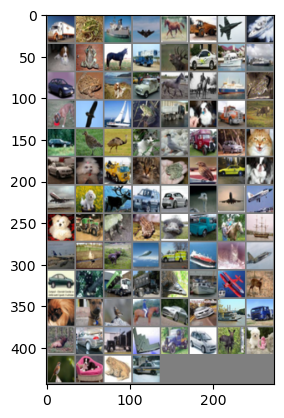

truck  frog  ship plane horse truck plane  ship   dog  frog horse truck  deer   car  ship  ship   car  frog   dog   car horse horse  ship  frog   dog  bird  ship  frog truck   dog truck  deer   car  bird  bird   cat  bird truck   car   cat   car   dog truck   cat  frog  bird   car   dog plane   dog  deer   car   car  bird plane plane   dog truck   cat  frog  bird   car horse  ship plane  bird  deer plane truck  ship   cat plane   car   cat truck truck  bird  ship plane  deer   dog   dog  bird horse   car   car  ship truck  deer   car truck plane truck   car  deer   dog  bird   dog  frog   car


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())

In [71]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if (j + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(i, j * len(image), len(train_loader.dataset), 100. * j / len(train_loader), loss.item()))

    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())




Train Epoch:0 [2900/50000 (6%)]	Loss: 2.311815
Train Epoch:0 [5900/50000 (12%)]	Loss: 2.301882
Train Epoch:0 [8900/50000 (18%)]	Loss: 2.301974
Train Epoch:0 [11900/50000 (24%)]	Loss: 2.302918
Train Epoch:0 [14900/50000 (30%)]	Loss: 2.305553
Train Epoch:0 [17900/50000 (37%)]	Loss: 2.185619


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_arr)
plt.show()